# Cassava Leaf Disease Classification Project

Cassava is a crucial crop for food security in many tropical regions. Detecting diseases in cassava leaves is vital for maintaining crop health and ensuring food production. Cassava Leaf Disease Classification problem using the dataset from Kaggle, following a structured approach encompassing Exploratory Data Analysis (EDA), Data Preprocessing, Model Engineering, and Evaluation & Analysis

## 1. Introduction
The objective of this project is to develop a model capable of classifying cassava leaves into different disease categories or identifying them as healthy. This is achieved by using a dataset from Kaggle, which contains labeled images of cassava leaves affected by various diseases.

In [ ]:
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc

In [7]:
train_dir = '/kaggle/input/cassava-leaf-disease-classification/train'
test_dir = '/kaggle/input/cassava-leaf-disease-classification/test'

## 2. Exploratory Data Analysis (EDA)
#### 2.1 Distribution of Classes
Assess the balance between different disease categories and healthy leaves.

In [8]:
# Function to get class distribution
def get_class_distribution(directory):
    class_counts = {}
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            class_counts[class_folder] = len(os.listdir(class_path))
    return class_counts

In [9]:
train_class_counts = get_class_distribution(train_dir)
test_class_counts = get_class_distribution(test_dir)

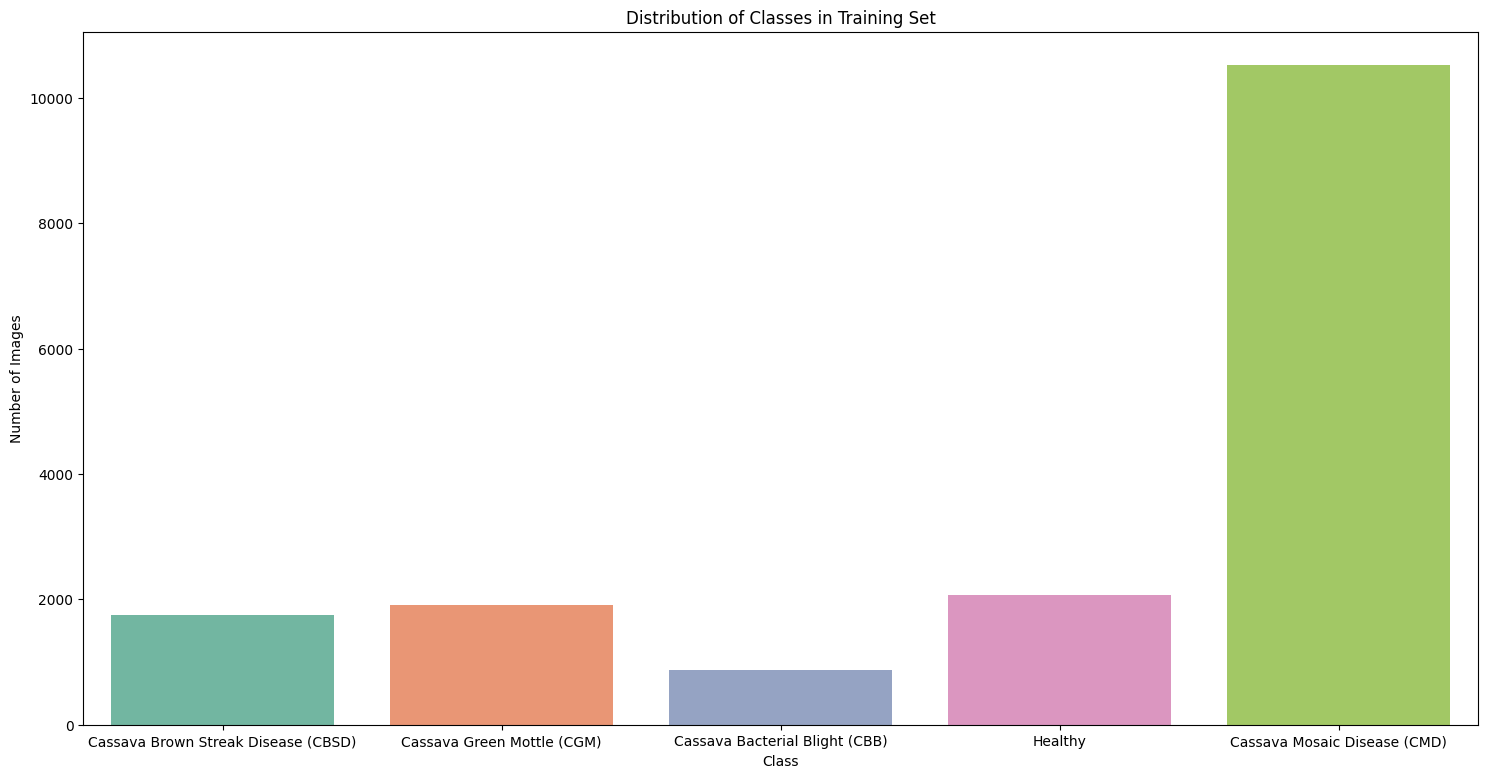

In [44]:
# Plotting the train class distribution
plt.figure(figsize=(18, 9))
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), palette='Set2')
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

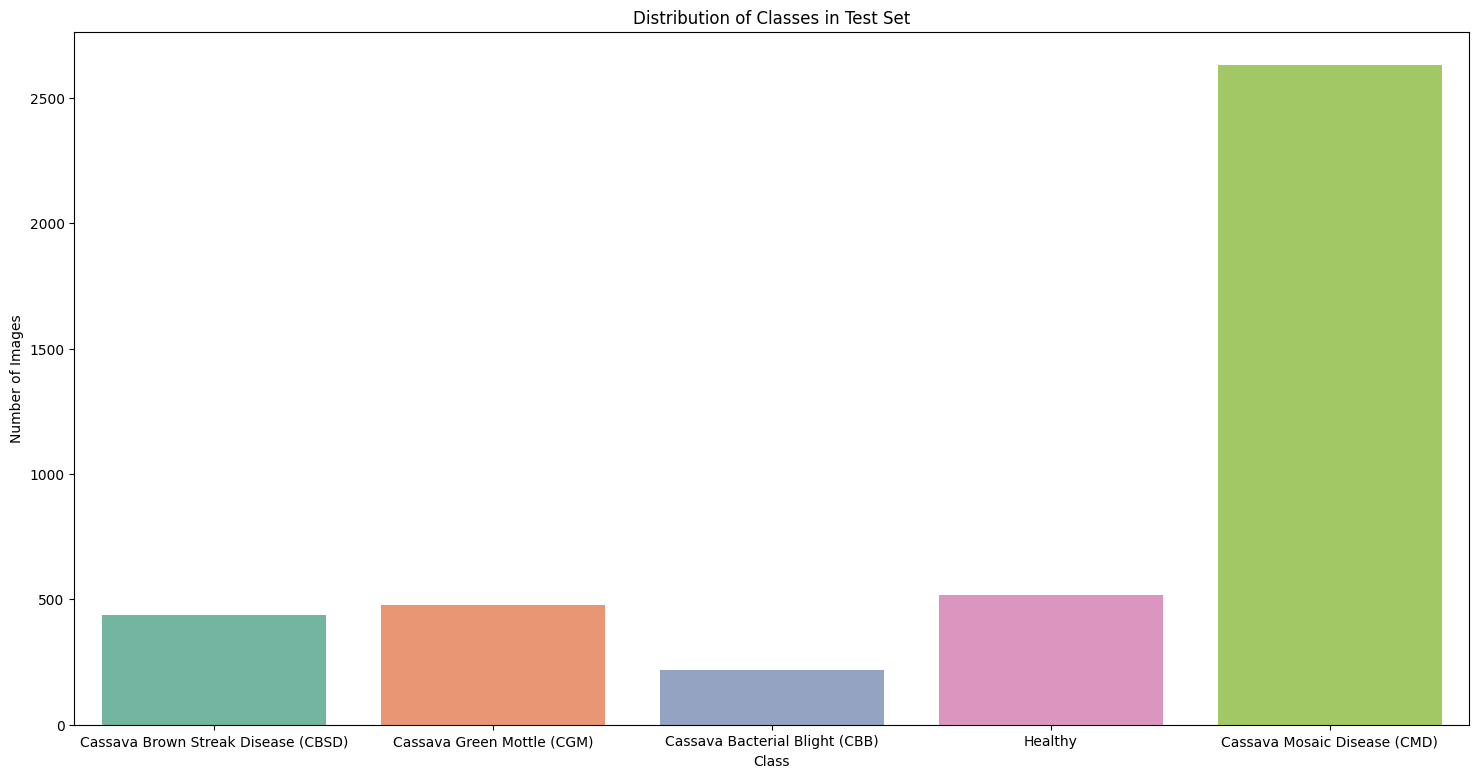

In [45]:
# Plotting the test class distribution
plt.figure(figsize=(18, 9))
sns.barplot(x=list(test_class_counts.keys()), y=list(test_class_counts.values()),palette='Set2')
plt.title('Distribution of Classes in Test Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

#### 2.2 Image Quality and Variability
Examine the images for quality, resolution, and variability among classes.

-display some train images with their corresponding labels.

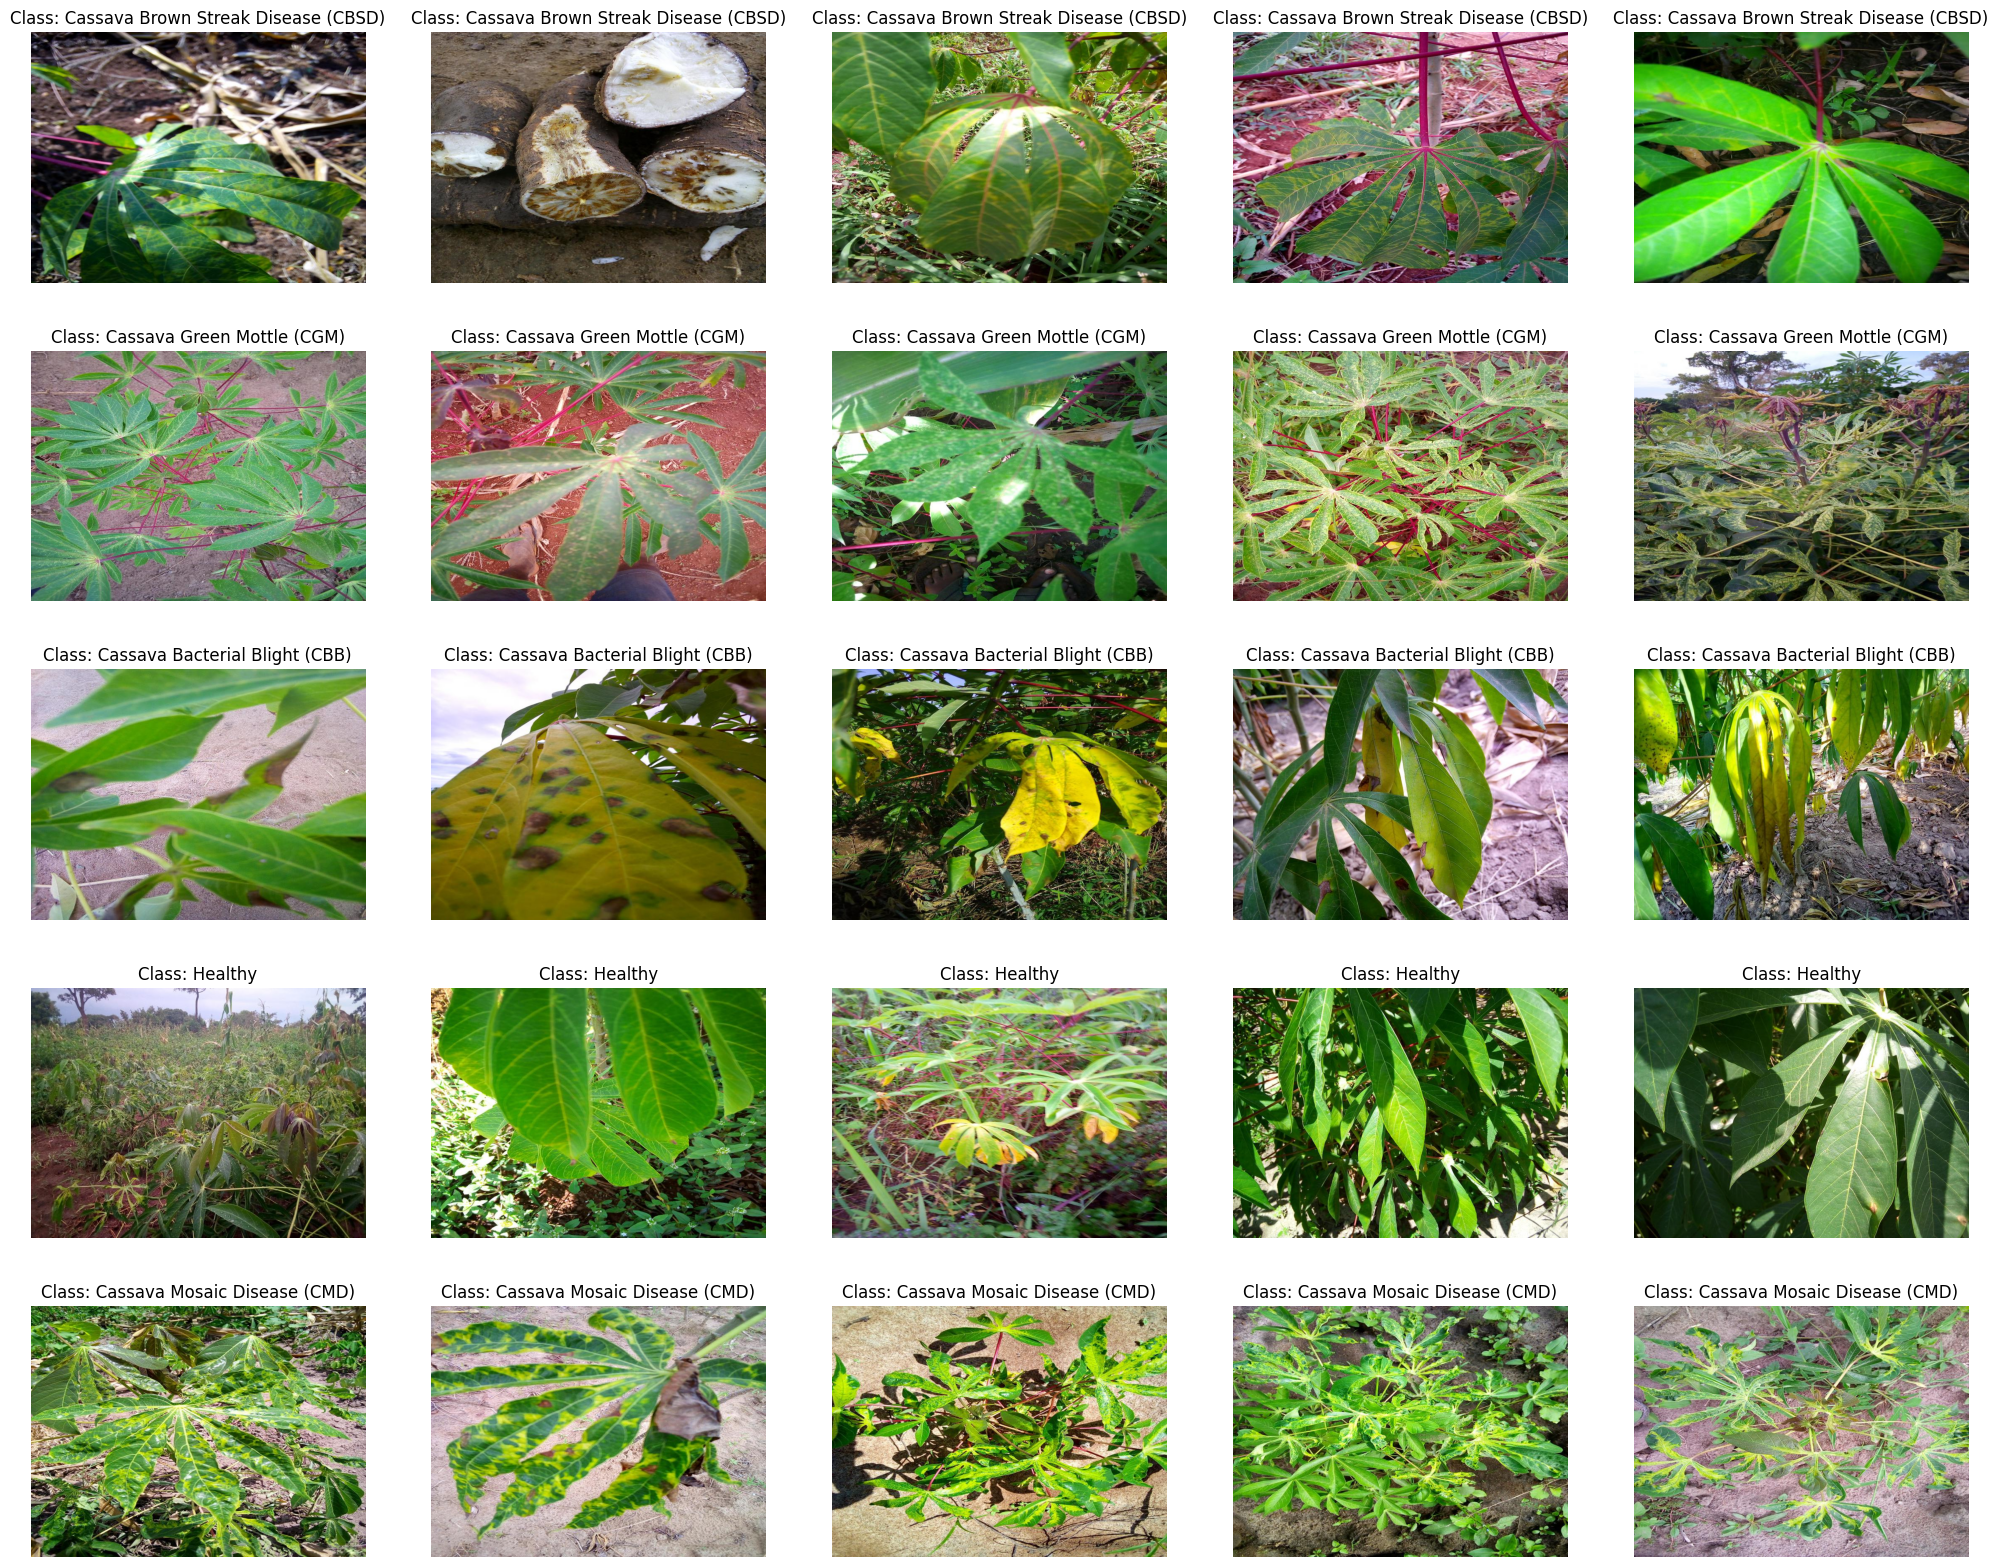

In [46]:
from PIL import Image

# Display sample images from each class
def show_sample_images(directory, num_samples=5):
    plt.figure(figsize=(25, 20))
    for i, class_folder in enumerate(os.listdir(directory)):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for j, img_name in enumerate(os.listdir(class_path)[:num_samples]):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path)
                plt.subplot(len(os.listdir(directory)), num_samples, i * num_samples + j + 1)
                plt.imshow(img)
                plt.title(f'Class: {class_folder}')
                plt.axis('off')
    plt.show()

show_sample_images(train_dir)

#### 2.3 Data Insights
Check for anomalies in image resolutions to identify any preprocessing needs.

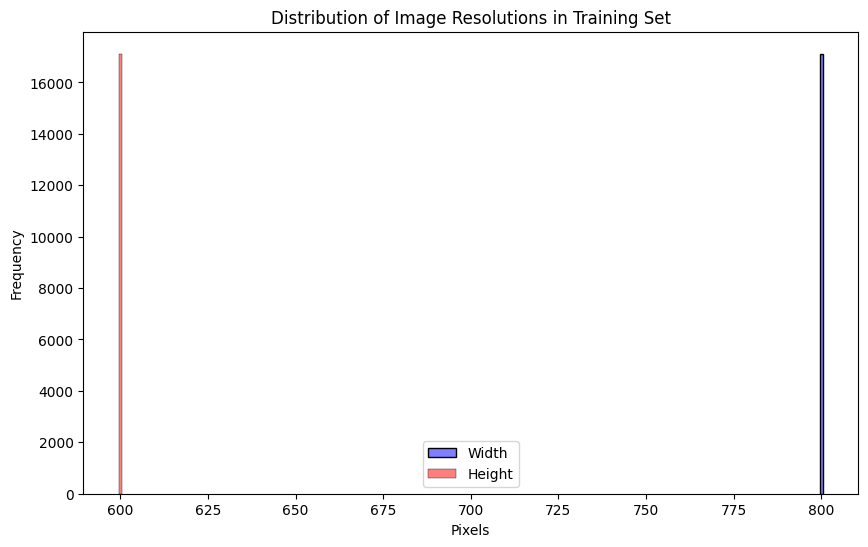

In [47]:
# Check for image resolution anomalies
def get_image_resolutions(directory):
    resolutions = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path)
                resolutions.append(img.size)
    return resolutions

train_resolutions = get_image_resolutions(train_dir)

# Plotting image resolutions
res_df = pd.DataFrame(train_resolutions, columns=['width', 'height'])
plt.figure(figsize=(10, 6))
sns.histplot(res_df['width'], kde=True, color='blue', label='Width')
sns.histplot(res_df['height'], kde=True, color='red', label='Height')
plt.title('Distribution of Image Resolutions in Training Set')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**The key findings are:**
1.	**Class Distribution**: The dataset is imbalanced with certain classes having more images than others.
2.	**Image Quality**: The images vary in resolution and quality.
3.	**Anomalies**: Some images have significantly different resolutions.


## 3. Data Preprocessing
#### 3.1 Image Resizing and Normalization
Standardized the size of all images to a fixed dimension while preserving the aspect ratio to ensure consistent input to the neural network. Next normalized pixel values to a range between 0 and 1, which facilitates faster convergence during training.

In [10]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### 3.2 Augmentation
Implemented data augmentation techniques to increase dataset diversity and reduce overfitting. 

In [11]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 4. Model Engineering
#### 4.1 Dataset Splitting
Dividing the dataset into training, validation, and test sets.

In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split

train_dataset = ImageFolder(train_dir, transform=augmentation_transforms)
test_dataset = ImageFolder(test_dir, transform=transform)

train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## 4.2 Model Architectures
Define and train multiple architecture


##### Common Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
num_classes = len(os.listdir(train_dir))
criterion = nn.CrossEntropyLoss()

#### Model Training Function
Here's the train_model function that is called for each model: 
   
   - Train each model for 10 epochs and evaluate their performance on the validation set.

In [14]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {running_loss/len(train_loader):.4f}, '
              f'Validation Loss: {val_loss/len(val_loader):.4f}, '
              f'Validation Accuracy: {100 * correct/total:.2f}%')


#### Convolutional Neural Network (CNN)
Define a simple CNN architecture

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

simple_cnn = SimpleCNN(num_classes)
optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=0.001)

# Train SimpleCNN
train_model(simple_cnn, optimizer_cnn, train_loader, val_loader)


Epoch 1/10, Train Loss: 1.1937, Validation Loss: 1.0418, Validation Accuracy: 61.88%
Epoch 2/10, Train Loss: 1.0526, Validation Loss: 1.0040, Validation Accuracy: 63.82%
Epoch 3/10, Train Loss: 1.0188, Validation Loss: 0.9601, Validation Accuracy: 64.45%
Epoch 4/10, Train Loss: 0.9926, Validation Loss: 0.9457, Validation Accuracy: 65.73%
Epoch 5/10, Train Loss: 0.9698, Validation Loss: 0.9777, Validation Accuracy: 66.24%
Epoch 6/10, Train Loss: 0.9441, Validation Loss: 0.9332, Validation Accuracy: 66.32%
Epoch 7/10, Train Loss: 0.9125, Validation Loss: 0.8708, Validation Accuracy: 68.15%
Epoch 8/10, Train Loss: 0.8887, Validation Loss: 0.8621, Validation Accuracy: 68.30%
Epoch 9/10, Train Loss: 0.8681, Validation Loss: 0.8511, Validation Accuracy: 68.46%
Epoch 10/10, Train Loss: 0.8436, Validation Loss: 0.8023, Validation Accuracy: 70.17%


#### Import Pre-trained Models

#### MobileNetV2

In [54]:

mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, num_classes)
optimizer_mobilenet = optim.Adam(mobilenet_v2.parameters(), lr=0.001)

# Train Mobilenet
train_model(mobilenet_v2, optimizer_mobilenet, train_loader, val_loader)


Epoch 1/10, Train Loss: 0.8244, Validation Loss: 0.7244, Validation Accuracy: 74.49%
Epoch 2/10, Train Loss: 0.6752, Validation Loss: 0.6712, Validation Accuracy: 76.25%
Epoch 3/10, Train Loss: 0.6250, Validation Loss: 0.6308, Validation Accuracy: 77.65%
Epoch 4/10, Train Loss: 0.6055, Validation Loss: 0.6150, Validation Accuracy: 78.04%
Epoch 5/10, Train Loss: 0.5858, Validation Loss: 0.5621, Validation Accuracy: 80.76%
Epoch 6/10, Train Loss: 0.5634, Validation Loss: 0.5609, Validation Accuracy: 80.65%
Epoch 7/10, Train Loss: 0.5642, Validation Loss: 0.6303, Validation Accuracy: 76.52%
Epoch 8/10, Train Loss: 0.5411, Validation Loss: 0.5561, Validation Accuracy: 79.36%
Epoch 9/10, Train Loss: 0.5386, Validation Loss: 0.5477, Validation Accuracy: 81.50%
Epoch 10/10, Train Loss: 0.5306, Validation Loss: 0.5437, Validation Accuracy: 80.96%


#### ResNet50

In [ ]:
"""
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
optimizer_resnet = optim.Adam(resnet50.parameters(), lr=0.001)

# Train ResNet50
train_model(resnet50, optimizer_resnet, train_loader, val_loader)
"""

#### VGG16

In [ ]:
"""
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
optimizer_vgg = optim.Adam(vgg16.parameters(), lr=0.001)

# Train VGG16
train_model(vgg16, optimizer_vgg, train_loader, val_loader)
"""

### EfficientNetB0/B1/B2
#### EfficientNetB0

In [ ]:
"""
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, num_classes)
optimizer_efficientnet_b0 = optim.Adam(efficientnet_b0.parameters(), lr=0.001)

# Train EfficientNetB0
train_model(efficientnet_b0, optimizer_efficientnet_b0, train_loader, val_loader)
"""

#### EfficientNetB1

In [ ]:
"""
efficientnet_b1 = models.efficientnet_b1(pretrained=True)
efficientnet_b1.classifier[1] = nn.Linear(efficientnet_b1.classifier[1].in_features, num_classes)
optimizer_efficientnet_b1 = optim.Adam(efficientnet_b1.parameters(), lr=0.001)

# Train EfficientNetB1
train_model(efficientnet_b1, optimizer_efficientnet_b1, train_loader, val_loader)
"""

#### EfficientNetB2

In [ ]:
"""
efficientnet_b2 = models.efficientnet_b2(pretrained=True)
efficientnet_b2.classifier[1] = nn.Linear(efficientnet_b2.classifier[1].in_features, num_classes)
optimizer_efficientnet_b2 = optim.Adam(efficientnet_b2.parameters(), lr=0.001)

# Train EfficientNetB2
train_model(efficientnet_b2, optimizer_efficientnet_b2, train_loader, val_loader)
"""

#### InceptionNet

In [ ]:
"""
inception = models.inception_v3(pretrained=True)
inception.fc = nn.Linear(inception.fc.in_features, num_classes)
optimizer_inception = optim.Adam(inception.parameters(), lr=0.001)

# Train InceptionNet
train_model(inception, optimizer_inception, train_loader, val_loader)
"""

## 5. Model Evaluation and Analysis
#### 5.1 Performance Testing
Here's the evaluate_model function to test the models on the test set:

In [34]:
def evaluate_model_with_images(model, test_loader, num_samples=6):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    images_sample = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
            
            # Collect samples for visualization
            if len(images_sample) < num_samples:
                images_sample.extend(images.cpu().numpy())
                if len(images_sample) > num_samples:
                    images_sample = images_sample[:num_samples]

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%')
    return accuracy, all_labels, all_preds, all_probs, images_sample


#### 5.2 Metrics Reporting
Evaluate each model and print the classification report:

In [35]:
def print_classification_report(labels, preds, model_name):
    report = classification_report(labels, preds, target_names=train_dataset.dataset.classes)
    print(f'\nClassification Report for {model_name}:\n')
    print(report)

#### 5.3 ROC Curve
Calculates the ROC curve for each model, and displays them

In [36]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_curve(y_true, y_probs, classes, model_name):
    num_classes = len(classes)
    y_true = label_binarize(y_true, classes=list(range(num_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()



#### 5.4 Display Test and Predicted Images with Labels

In [37]:
def show_sample_images_with_predictions(images, true_labels, predicted_labels, classes, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        img = images[i].transpose((1, 2, 0))  # convert to HWC format
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(img)
        plt.title(f'True: {classes[true_labels[i]]}\nPred: {classes[predicted_labels[i]]}')
        plt.axis('off')
    plt.show()


Test Loss: 0.7582, Test Accuracy: 72.38%

CNN - Test Accuracy: 72.38%

Display Some Test & predicted Images with Labels


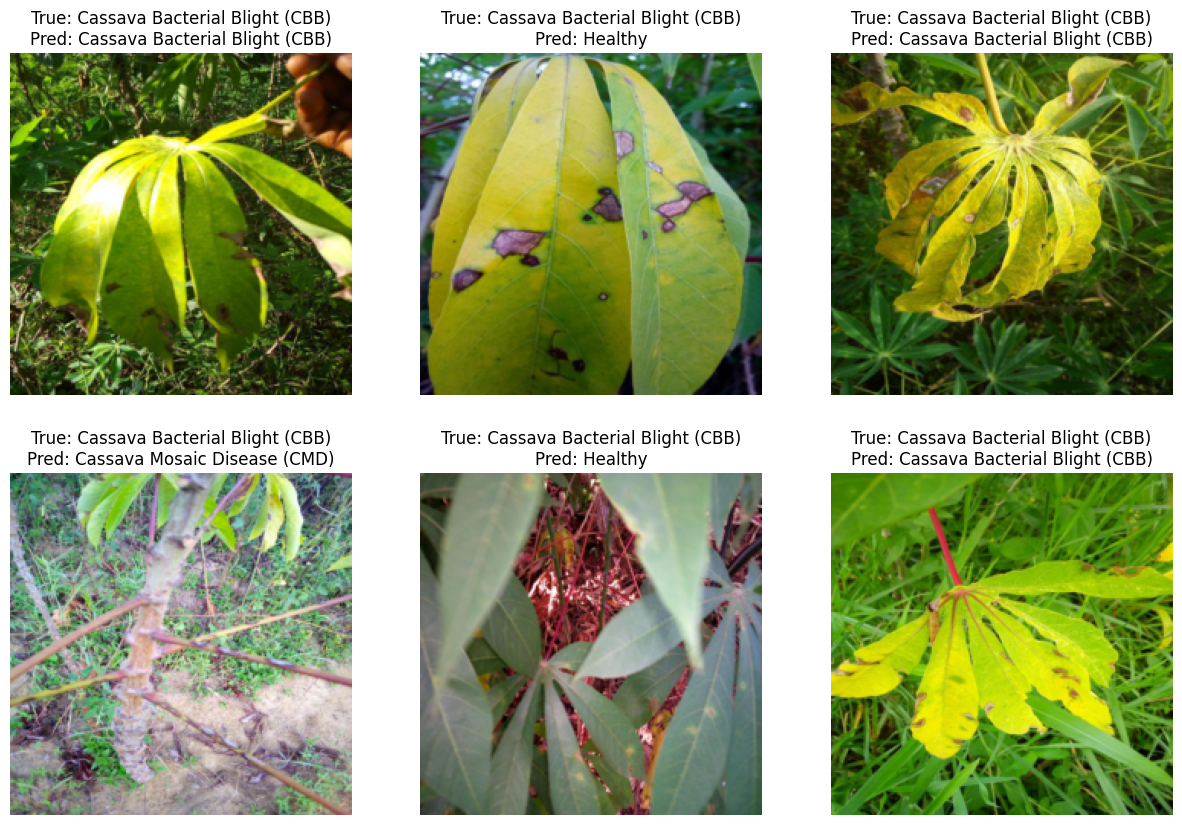

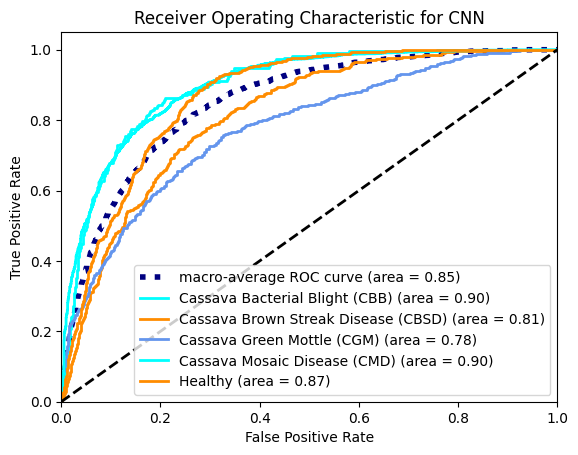


Classification Report for CNN:

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.43      0.38      0.40       217
Cassava Brown Streak Disease (CBSD)       0.57      0.32      0.41       438
         Cassava Green Mottle (CGM)       0.57      0.33      0.42       477
       Cassava Mosaic Disease (CMD)       0.80      0.96      0.87      2632
                            Healthy       0.47      0.39      0.43       516

                           accuracy                           0.72      4280
                          macro avg       0.57      0.47      0.51      4280
                       weighted avg       0.69      0.72      0.70      4280



In [42]:
# Evaluate and plot ROC for each model
models = {
    'CNN': simple_cnn
    
    #'MobileNetV2': mobilenet_v2,
    #'ResNet50': resnet50,
    #'VGG16': vgg16,
    #'EfficientNetB0': efficientnet_b0,
    #'EfficientNetB1': efficientnet_b1,
    #'EfficientNetB2': efficientnet_b2,
    #'InceptionNet': inception
    
}

for model_name, model in models.items():
    #Model evaloation
    accuracy, all_labels, all_preds, all_probs, images_sample = evaluate_model_with_images(model, test_loader)
    print(f'\n{model_name} - Test Accuracy: {accuracy:.2f}%')
    
    # Evaluate and show images for each model
    print('\nDisplay Some Test & predicted Images with Labels')
    show_sample_images_with_predictions(images_sample, all_labels[:len(images_sample)], all_preds[:len(images_sample)], train_dataset.dataset.classes)
   
    # Show Roc curve
    plot_roc_curve(all_labels, np.array(all_probs), train_dataset.dataset.classes, model_name)
    
    # Show classification report
    print_classification_report(all_labels, all_preds, model_name)

## 6. Conclusion
This comprehensive code trains and evaluates Convoluation Nueral Network (CNN) model for the Cassava Leaf Disease Classification task, display performance metrics. if computational resources are limited we can traine and evaluate multiple architectures (MobileNetV2, ResNet50, VGG16, EfficientNetB0/B1/B2, InceptionNet) on the Cassava Leaf Disease Classification dataset. 